<a href="https://colab.research.google.com/github/Gorphe/Howard-Gugger-Book/blob/main/13_convolutional_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

THE MAGIC OF CONVOLUTIONS

In [1]:
from fastai.vision.all import *

In [2]:
top_edge = tensor([
    [-1,-1,-1],
    [0, 0, 0],
    [1, 1 ,1]
]).float()

#should be named down_edge

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

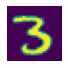

In [4]:
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3)

In [5]:
im3_t = tensor(im3)

In [6]:
targ = im3_t[0:3,0:3]

In [ ]:
targ

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=torch.uint8)

In [7]:
conv = im3_t[0:3, 0:3]*top_edge

In [ ]:
conv

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [8]:
conv.sum()

tensor(0.)

In [9]:
import pandas as pd
df = pd.DataFrame(im3_t[:10,:20])

In [10]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [11]:
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [12]:
(im3_t[4:7, 6:9] *top_edge).sum()

tensor(762.)

In [13]:
(im3_t[7:10,17:20]*top_edge).sum()

tensor(-29.)

In [14]:
def apply_kernel(row, col, kernel):
  return (im3_t[row-1:row+2, col-1:col+2]*kernel).sum()


In [15]:
apply_kernel(5,7,top_edge)

tensor(762.)

In [16]:
rng = range(1,27)

top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])


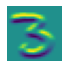

In [17]:
show_image(top_edge3)

In [ ]:
top_edge3
#this is not top edges, but down edges

In [20]:
left_edge = tensor([
                    [-1,1,0],
                    [-1,1,0],
                    [-1,1,0]
]).float()
#should be named right_edge, by the way

In [21]:
left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])

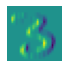

In [23]:
show_image(left_edge3)

In [ ]:
# this is not left edges, but right edges

Convolutions in pytorch

In [22]:
diag1_edge = tensor([
                     [0, -1, 1],
                     [-1, 1, 0],
                     [1, 0, 0]
]).float()
# why not last [1,0,-1] ?

diag2_edge = tensor([
                     [1,-1,0],
                     [ 0,1,-1],
                     [0,0,1]
]).float()
#why not last [-1,0,1] ?


In [24]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [25]:
mnist = DataBlock(
    (ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items = get_image_files,
    splitter = GrandparentSplitter(),
    get_y = parent_label
)

dls = mnist.dataloaders(path)
xb, yb = first(dls.valid)
xb.shape


torch.Size([64, 1, 28, 28])

In [26]:
xb, yb = to_cpu(xb), to_cpu(yb)

In [27]:
edge_kernels.shape, edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [29]:
edge_kernels = edge_kernels.unsqueeze(1)

In [30]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

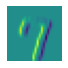

In [31]:
show_image(batch_features[0,0])

Strides and padding

understanding the convolution equations

OUR FIRST CONVOLUTIONAL NEURAL NETWORK

In [33]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [34]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [39]:
broken_cnn = sequential(
    nn.Conv2d(1,30,kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,1,kernel_size=3, padding=1)
)

In [40]:
broken_cnn

Sequential(
  (0): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(30, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [50]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

In [55]:
def conv(ni, nf, ks=3, act=True):
  res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2) # // et pas / 
  if act:
    res = nn.Sequential(res, nn.ReLU())
  return res

In [56]:
simple_cnn = sequential(      # input is 28*28
    conv(1,4),                # 14*14
    conv(4,8),                # 7*7
    conv(8,16),               # 4*4
    conv(16,32),              # 2*2
    conv(32,2, act=False),    # 1*1
    Flatten()
)

In [60]:
# debugging
simple_cnn2 = sequential(      # input is 28*28
    nn.Conv2d(1,4, stride=2,kernel_size=3, padding=1),    
    nn.ReLU(),  
    nn.Conv2d(4,8, stride=2,kernel_size=3, padding=1),        
    nn.ReLU(),   
    nn.Conv2d(8,16, stride=2, kernel_size=3, padding=1),              
    nn.ReLU(),   
    nn.Conv2d(16,32, stride=2,kernel_size=3, padding=1),             
    nn.ReLU(), 
    nn.Conv2d(32,2, stride=2,kernel_size=3, padding=1),                 
    Flatten()
)

In [65]:
#test 
simple_cnn3 = sequential(      # input is 28*28
    conv(1,1),                # 14*14
    conv(1,1),                # 7*7
    conv(1,1),               # 4*4
    conv(1,1),              # 2*2
    conv(1,1, act=False),    # 1*1
    Flatten()
)

In [66]:
simple_cnn3(xb).shape

torch.Size([64, 1])

In [63]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [64]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [67]:
learn.fit_one_cycle(2,0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.060558,0.033095,0.989696,00:16
1,0.018126,0.021718,0.992149,00:16


Understanding convolution arithmetic

In [69]:
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [70]:
m[0].weight.shape

torch.Size([4, 1, 3, 3])

In [71]:
m[0].bias.shape

torch.Size([4])

Receptive fields

IMPROVING TRAINING STABILITY

In [75]:
path = untar_data(URLs.MNIST)

In [77]:
def get_dls(bs=64):
  return DataBlock(
      blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
      get_items = get_image_files,
      splitter=GrandparentSplitter('training', 'testing'),
      get_y=parent_label,
      batch_tfms=Normalize()
  ).dataloaders(path, bs=bs)

In [81]:
dls = get_dls()

In [80]:
dls

<function __main__.get_dls>

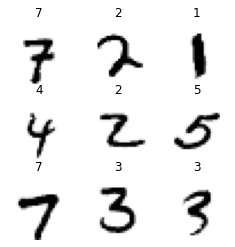

In [82]:
dls.show_batch(max_n=9, figsize=(4,4))

A simple baseline

In [83]:
def conv(ni, nf, ks=3, act=True):
  res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2) # // et pas / 
  if act:
    res = nn.Sequential(res, nn.ReLU())
  return res

In [84]:
def simple_cnn():
  return sequential(
      conv(1,8,ks=5),   #14x14
      conv(8,16),       #7x7
      conv(16,32),      #4x4
      conv(32,64),      #2x2
      conv(64,10, act=False), #1x1
      Flatten()
  )

In [85]:
from fastai.callback.hook import *

In [86]:
def fit(epochs=1):
  learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=True))
  learn.fit(epochs, 0.06)
  return learn

In [87]:
learn=fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:72: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.307075,2.302862,0.103200,01:30


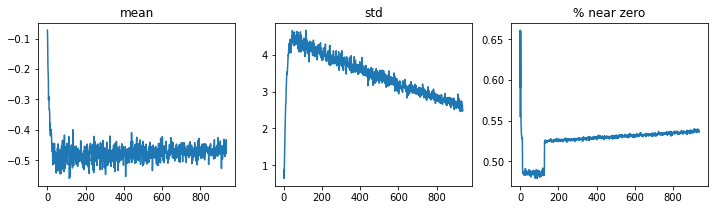

In [88]:
learn.activation_stats.plot_layer_stats(0)

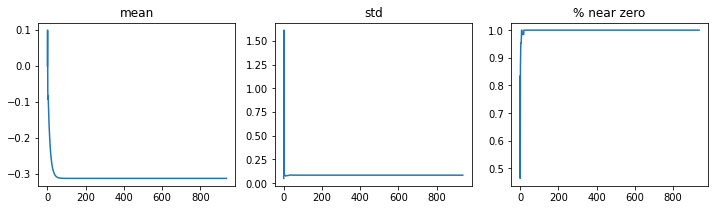

In [89]:
learn.activation_stats.plot_layer_stats(-2)

Increase batch size

In [90]:
dls=get_dls(512)

In [91]:
learn=fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:72: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.314630,2.303786,0.113500,01:17


1 cycle training

In [96]:
def fit(epochs=1, lr=0.06):
  learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=True))
  learn.fit_one_cycle(epochs, lr)
  return learn

In [97]:
learn=fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:72: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.201497,0.066356,0.979300,01:18


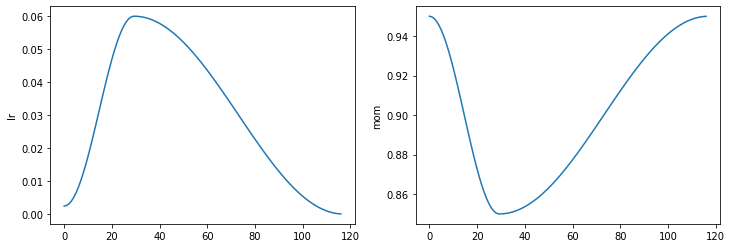

In [98]:
learn.recorder.plot_sched()

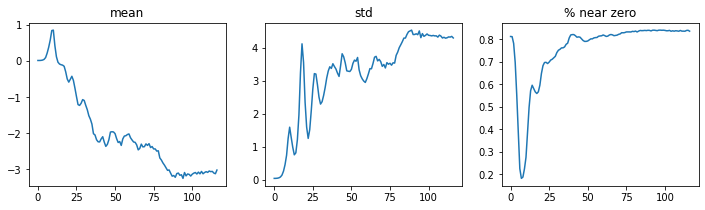

In [100]:
learn.activation_stats.plot_layer_stats(-2)

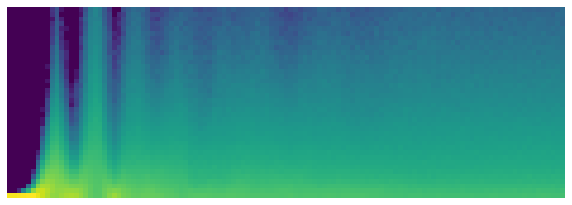

In [101]:
learn.activation_stats.color_dim(-2)

Batch normalization

In [102]:
def conv(ni, nf, ks=3, act=True):
  layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
  layers.append(nn.BatchNorm2d(nf))
  if act:
    layers.append(nn.ReLU())
  return nn.Sequential(*layers)

In [103]:
learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:72: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.132540,0.056156,0.986900,01:20


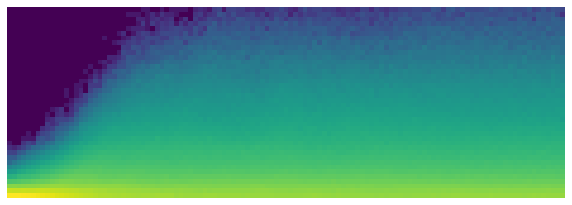

In [104]:
learn.activation_stats.color_dim(-4)

In [ ]:
learn = fit(5, lr=0.1)

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:72: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.185855,0.098905,0.970500,01:20
1,0.081135,0.051511,0.982500,01:20
2,0.055304,0.050059,0.984700,01:21
3,0.033879,0.028964,0.991800,01:20
